In [1]:
from pathlib import Path

DATA_DIR = Path.cwd().parent / "data"

DATA_DIR

PosixPath('/workspaces/mnist/data')

# Dataset

In [2]:
from datasets import load_dataset

ds = load_dataset("ylecun/mnist")

ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [3]:
ds["train"].features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], id=None)}

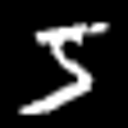

In [4]:
example = ds["train"][0]

example["image"].resize((128, 128))

In [5]:
example["label"]

5

In [6]:
labels = ds["train"].features["label"].names

labels

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [7]:
# print image channels
example["image"].convert("RGB")

In [8]:
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for i, label in enumerate(labels)}

label2id

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

# Model

In [9]:
from transformers import AutoImageProcessor

# https://huggingface.co/google/vit-base-patch16-224#preprocessing
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224", use_fast=True)

processor

ViTImageProcessorFast {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessorFast",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [10]:
from transformers import ViTForImageClassification

base_model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=10,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


test to ensure dataset is consumable by model

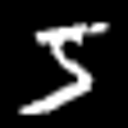

In [11]:
img = ds["train"][0]["image"]

img.resize((128, 128))

In [12]:
inputs = processor(img, return_tensors="pt")
inputs.keys()

dict_keys(['pixel_values'])

In [13]:
outputs = base_model(**inputs)
outputs

ImageClassifierOutput(loss=None, logits=tensor([[ 0.1310,  0.6511, -0.1524, -0.2226, -0.2744,  0.5164, -0.2700,  0.0285,
          0.5215,  1.1842]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [14]:
outputs.logits.shape

torch.Size([1, 10])

In [15]:
cls_idx = outputs.logits.argmax(-1).item()

id2label[cls_idx]

'9'

# Preprocessing

In [16]:
def preprocess(batch):
    # convert images to pixels tensor
    inputs = processor(batch["image"], return_tensors="pt")

    return {
        "image": batch["image"],
        "pixel_values": inputs["pixel_values"],
        "label": batch["label"]
    }

In [17]:
prepared_ds = ds.with_transform(preprocess)

x = prepared_ds['train'][0:2]

x["pixel_values"].shape, x["label"]

(torch.Size([2, 3, 224, 224]), [5, 0])

# Training

In [18]:
import torch
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(p):
    preds = torch.argmax(torch.tensor(p.predictions), dim=1)
    return metric.compute(predictions=preds, references=p.label_ids)

def collate(batches):
    pixel_values = torch.stack([batch["pixel_values"] for batch in batches])
    labels = torch.tensor([batch["label"] for batch in batches])
    return {"pixel_values": pixel_values, "labels": labels}

## Fine-Tuning

### Initialize Classifier

In [19]:
for param in base_model.vit.parameters():
    param.requires_grad = False  # freeze vit backbone

for param in base_model.classifier.parameters():
    param.requires_grad = True  # train only classifier
    
target_params = [name for name, param in base_model.named_parameters() if param.requires_grad]
for name in target_params:
    print(name)

classifier.weight
classifier.bias


In [20]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir=DATA_DIR / "models" / "google-vit-patch16-224" / "ft",
    run_name="google-vit-patch16-224-ft",
    num_train_epochs=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    optim="adamw_torch",
    learning_rate=1e-3,
    torch_compile=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir=DATA_DIR / "logs" / "google-vit-patch16-224" / "ft",
    report_to="wandb",
    remove_unused_columns=False, # preserves "image" column for preprocessing
    data_seed=42,
)

trainer = Trainer(
    model=base_model,
    processing_class=processor,
    args=training_args,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["test"],
    data_collator=collate,
    compute_metrics=compute_metrics,
)

trainer.get_num_trainable_parameters()

7690

In [21]:
trainer.train()

ft_model = trainer.model

wandb: Currently logged in as: mrbrobot (cloudbend). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.175300,0.151133,0.954200
2,0.121400,0.126409,0.962300


### Classifier/Encoder Coadaptation

In [22]:
for param in ft_model.vit.parameters():
    param.requires_grad = False  # freeze vit backbone

for param in ft_model.vit.encoder.layer[-1].parameters():
    param.requires_grad = True  # unfreeze last encoder layer

for param in ft_model.classifier.parameters():
    param.requires_grad = True  # unfreeze classifier
    
target_params = [name for name, param in ft_model.named_parameters() if param.requires_grad]
for name in target_params:
    print(name)

vit.encoder.layer.11.attention.attention.query.weight
vit.encoder.layer.11.attention.attention.query.bias
vit.encoder.layer.11.attention.attention.key.weight
vit.encoder.layer.11.attention.attention.key.bias
vit.encoder.layer.11.attention.attention.value.weight
vit.encoder.layer.11.attention.attention.value.bias
vit.encoder.layer.11.attention.output.dense.weight
vit.encoder.layer.11.attention.output.dense.bias
vit.encoder.layer.11.intermediate.dense.weight
vit.encoder.layer.11.intermediate.dense.bias
vit.encoder.layer.11.output.dense.weight
vit.encoder.layer.11.output.dense.bias
vit.encoder.layer.11.layernorm_before.weight
vit.encoder.layer.11.layernorm_before.bias
vit.encoder.layer.11.layernorm_after.weight
vit.encoder.layer.11.layernorm_after.bias
classifier.weight
classifier.bias


In [23]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir=DATA_DIR / "models" / "google-vit-patch16-224" / "ft",
    run_name="google-vit-patch16-224-ft",
    num_train_epochs=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    optim="adamw_torch",
    learning_rate=1e-3,
    torch_compile=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir=DATA_DIR / "logs" / "google-vit-patch16-224" / "ft",
    report_to="wandb",
    remove_unused_columns=False, # preserves "image" column for preprocessing
    data_seed=42,
)

trainer = Trainer(
    model=ft_model,
    processing_class=processor,
    args=training_args,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["test"],
    data_collator=collate,
    compute_metrics=compute_metrics,
)

trainer.get_num_trainable_parameters()

7095562

In [24]:
trainer.train()

ft_model = trainer.model

Epoch,Training Loss,Validation Loss,Accuracy
1,0.119200,0.116543,0.963500
2,0.092600,0.102577,0.968300


## PEFT

In [25]:
from peft import get_peft_model, LoraConfig

peft_config = LoraConfig(
    r=8, # rank of update matrices
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    target_modules=["query", "key", "value"], # layers to apply lora to
)

peft_model = get_peft_model(ft_model, peft_config)

In [26]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir=DATA_DIR / "models" / "google-vit-patch16-224" / "peft",
    run_name="google-vit-patch16-224-peft",
    num_train_epochs=4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    optim="adamw_torch",
    learning_rate=1e-3,
    eval_strategy="epoch",
    save_strategy="epoch",
    # load_best_model_at_end=True, # currently casues KeyError: 'eval_loss' after 1st epoch
    logging_dir=DATA_DIR / "logs" / "google-vit-patch16-224" / "peft",
    report_to="wandb",
    remove_unused_columns=False, # preserves "image" column for preprocessing
    data_seed=42,
)

trainer = Trainer(
    model=peft_model,
    processing_class=processor,
    args=training_args,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["test"],
    data_collator=collate,
    compute_metrics=compute_metrics,
)

trainer.get_num_trainable_parameters()

442368

In [27]:
trainer.train()

model = peft_model.merge_and_unload()

Epoch,Training Loss,Validation Loss
1,0.040100,No log
2,0.023700,No log
3,0.007700,No log
4,0.000900,No log


In [ ]:
from evaluate import evaluator
from transformers import pipeline

eval = evaluator("image-classification")

pipe = pipeline("image-classification", model=model, feature_extractor=processor, use_fast=True)

result = eval.compute(
    model_or_pipeline=pipe,
    data=ds["test"],
    metric="accuracy",
    input_column="image",
    label_column="label",
    label_mapping=label2id,
    random_state=42,
)


result["accuracy"]

Device set to use cuda:0


0.9958